# Clase Tutorial 3: Feature Engineering

* En 2014, el artículo ["Practical Lessons from Predicting Clicks on Ads at Facebook"](https://oreil.ly/oS16J) destacó que tener las features correctas es lo más importante en el desarrollo de modelos de Machine Learning.
* Desde entonces, muchas empresas comprobaron que, una vez que tienen un modelo funcional, <span style="color: blue;">contar con las features adecuadas suele generar el mayor aumento en rendimiento</span>, superando técnicas algorítmicas avanzadas como el ajuste de hiperparámetros.
* Incluso las arquitecturas de modelos más avanzadas pueden tener un mal desempeño si no utilizan un buen conjunto de features.
* Dada su importancia, una gran parte del trabajo de los ingenieros de ML consiste en desarrollar nuevas features útiles.
* En esta clase, vamos a explorar técnicas comunes y consideraciones importantes en la ingeniería de features. También, vamos a dedicar una porción de la clase a un problema sutil pero devastador que afecta a muchos sistemas de ML en producción: la fuga de datos (data leakage).

## Learned Features vs. Engineered Features

#### 🤔 ¿Por qué es necesario preocuparse por la ingeniería de features si el deep learning promete automatizar este proceso?

* Es cierto que la promesa del deep learning es que no necesitamos crear características manualmente. Por eso, el deep learning a veces se llama <span style="color: blue;">"aprendizaje de features" o "feature learning".</span>
* Muchos <span style="color: blue;">features pueden ser aprendidos y extraídos automáticamente por los algoritmos.</span>
* Sin embargo, todavía estamos lejos del punto en el que todas las características puedan ser automatizadas. Además, hasta el momento, la mayoría de las aplicaciones de ML en producción no utilizan deep learning.

> Ejemplo:

 * Queremos construir un clasificador para determinar si un comentario es spam o no.
 * Antes del deep learning, al recibir un texto, tendrías que aplicar manualmente técnicas clásicas de procesamiento de texto como lematización, expansión de contracciones, eliminación de puntuación y pasar todo a minúsculas. Luego, podrías querer dividir tu texto en n-gramas con valores de n de tu elección.

 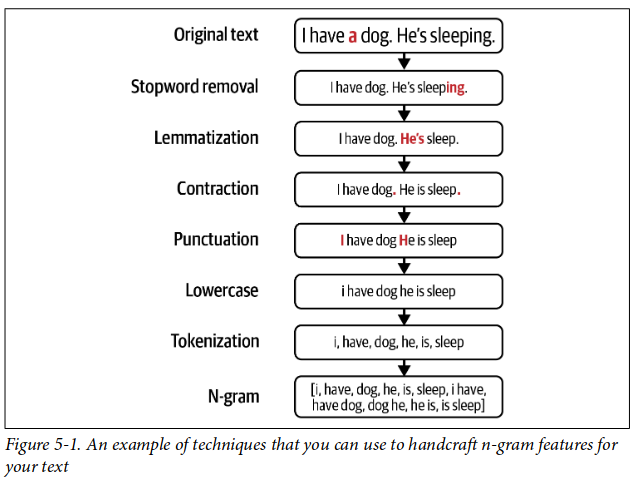

<div style="background-color: #f9f9f9; border-left: 4px solid #4CAF50; padding: 10px; font-size: 0.9em;">
<b>Definición.</b> 

<b>N-gram:</b> Secuencia contigua de n elementos de una muestra de texto dada. Los elementos pueden ser fonemas, sílabas, letras o palabras. 

Por ejemplo, dado el texto “Me gusta la comida”:
* N-gramas a nivel de palabras con n=1: ["Me", "gusta", "la", "comida"]
* N-gramas a nivel de palabras con n=2: ["Me gusta", "gusta la", "la comida"]
* Conjunto de características de n-gramas para esta oración, si queremos n=1 y n=2, es: ["Me", "gusta", "la", "comida", "Me gusta", "gusta la", "la comida"].

</div>


 * Una vez generados n-gramas para los datos de entrenamiento, podemos crear un <span style="color: blue;">vocabulario</span> que asocie cada n-grama con un índice.
 * Así podemos convertir cada <span style="color: blue;">texto en un vector basado en los índices de sus n-gramas.</span>
   * Por ejemplo, si tenemos un vocabulario de n-gramas como se muestra a continuación:

        | me | gusta | la | comida | rica | me gusta | gusta la | la comida | comida rica |
        |----|-------|----|--------|------|----------|----------|-----------|-----------|
        | 0  |   1   |  2 |   3    |  4   |    5     |    6     |     7     |     8     | 

 * Cada elemento en el vector corresponde al número de veces que el n-grama en ese índice aparece en el comentario.
 * “Me gusta la comida" será codificado como el vector [1, 1, 1, 1, 0, 1, 1, 1, 0]. Este vector puede luego ser usado como entrada en un modelo de ML.


Feature engineering <span style="color: blue;">requiere conocimiento de técnicas específicas del dominio.</span>
* En el ejemplo previo, el dominio es el procesamiento de lenguaje natural (NLP) y el idioma nativo del texto. 

Feature engineering tiende a ser un <span style="color: blue;">proceso iterativo y frágil</span> (podes olvidarte de ciertos pasos o usar alguna técnica que no performa bien).
* Desde el surgimiento del <span style="color: blue;">deep learning</span>, en lugar de preocuparnos por la lematización, puntuación o eliminación de palabras vacías, podemos dividir el texto en palabras (tokenización), crear un vocabulario a partir de esas palabras y convertir cada una de ellas en vectores de one-hot usando este vocabulario. 
    * El <span style="color: blue;">modelo aprenderá a extraer características</span> útiles a partir de esto. 
    * Así, <span style="color: blue;">gran parte del feature engineering</span> para texto ha sido <span style="color: blue;">automatizado.</span> 

* Se han hecho <span style="color: blue;">progresos similares para imágenes</span>. Por ejemplo, en lugar de tener que extraer características manualmente de imágenes crudas y pasar esas características a los modelos de ML, podemos ingresar imágenes crudas directamente en tus modelos de deep learning. 

Sin embargo, un <span style="color: blue;">sistema de ML probablemente necesitará datos más allá de solo texto e imágenes.</span>
* Por ejemplo, al detectar si un comentario es spam o no, además del texto en el comentario en sí, podrías querer usar otra información sobre:

    - El comentario: ¿Cuántos votos positivos o negativos tiene?
    - El usuario que publicó el comentario: ¿Cuándo se creó esta cuenta, con qué frecuencia publica y cuántos votos positivos o negativos tiene?
    - El hilo en el que se publicó el comentario: ¿Cuántas vistas tiene? Los hilos populares tienden a atraer más spam.
    
        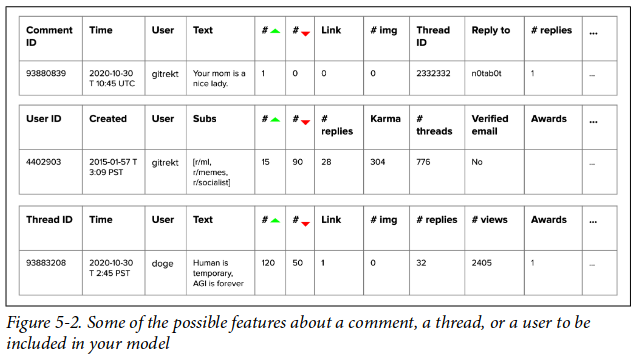

    - Hay muchas características posibles para usar: el proceso de elegir qué información utilizar y cómo extraer esta información en un formato usable por tus modelos de ML es la <span style="color: blue;">__ingeniería de features__</span>. 
        - Para <span style="color: blue;">tareas complejas</span> como recomendar videos para que los usuarios vean a continuación en TikTok, el <span style="color: blue;">número de características utilizadas puede llegar a millones.</span> 
        - Para <span style="color: blue;">tareas específicas</span>  de un dominio, como predecir si una transacción es fraudulenta, es posible que necesites experiencia en el área bancaria y fraudes para poder generar características útiles.

## 2. Operaciones Comunes en el Feature Engineering

### 2.1 Manejo de Valores Faltantes 🧐

- Una de las primeras cosas que podrías notar al trabajar con datos en producción es que algunos valores están ausentes. 
- No todos los tipos de valores faltantes son iguales: hay tres tipos.
- Para entender esto, vamos a considerar la tarea de predecir si alguien comprará una casa en los próximos 12 meses.

    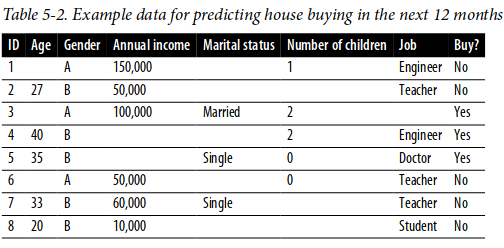

    #### 2.1.1 Faltantes no al azar (MNAR, Missing Not At Random)
    - La razón por la que falta un valor<span style="color: blue;">se debe al valor verdadero en sí.</span> 
    - En el ejemplo, podríamos notar que algunos encuestados no divulgaron su <span style="color: blue;">ingreso</span>. Al investigar, puede resultar que el ingreso de los encuestados que no reportaron tiende a ser más alto que el de aquellos que sí divulgaron. Es decir, los valores de ingreso faltan por razones relacionadas con los valores mismos.

        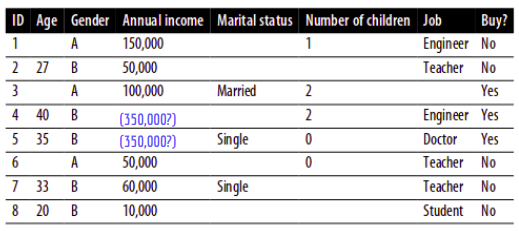

    #### 2.1.2 Faltantes al azar (MAR, Missing At Random)
    - La razón por la que falta un valor no <span style="color: blue;">se debe</span> al valor en sí, sino <span style="color: blue;">a otra variable observada</span>. 
    - En el ejemplo, podríamos notar que los valores de <span style="color: blue;">edad</span> a menudo faltan para los encuestados del <span style="color: pink;">género "A"</span>, lo cual podría ser porque las personas del género A en esta encuesta no les gusta divulgar su edad.

        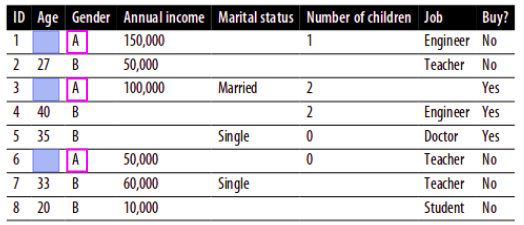

    #### 2.1.3 Faltantes completamente al azar (MCAR, Missing Completely At Random)
    - <span style="color: blue;">No hay un patrón</span> que indique en que momento falta el valor. 
    - En el ejemplo, podríamos pensar que los valores faltantes para la columna <span style="color: blue;">“Trabajo”</span> podrían ser completamente aleatorios, no por el trabajo en sí ni por ninguna otra variable. 
    - Las personas simplemente olvidan llenar ese valor a veces sin razón particular. 
    - Sin embargo... este tipo de falta es <span style="color: blue;">muy raro: generalmente hay razones</span> por las cuales ciertos valores faltan, y deberías investigarlas.

        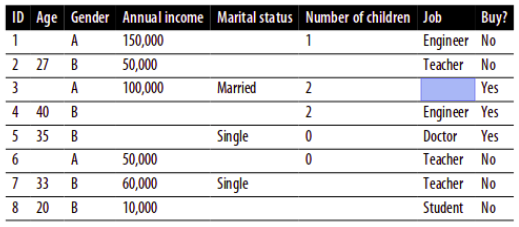


Cuando encontramos valores faltantes, podemos rellenarlos con ciertos valores (__imputación__) o eliminarlos (__eliminación__):

#### 🗑️ Eliminación

Muchos tienden a preferir la eliminación, no porque sea el mejor método, sino porque es más fácil de hacer. 
1. __Eliminar columnas__: eliminar columnas a las que les faltan demasiadas entradas.
    - Desventajas: incluso si faltan la mitad de los valores, los datos restantes siguen siendo información potencialmente útil para las predicciones.
    - Ejemplo, incluso si falta más de la mitad de la columna "Marital status", el estado civil sigue estando altamente correlacionado con la compra de vivienda.

2. __Eliminar filas__: eliminar muestras que tienen valores faltantes.
    - <font color='green'>Buen caso de uso:</font> faltan datos completamente al azar <span style="color: blue;">(MCAR)</span> y el <span style="color: blue;">número de ejemplos</span> con valores faltantes <span style="color: blue;">es chico</span> (ej, < del 0.1%). 
        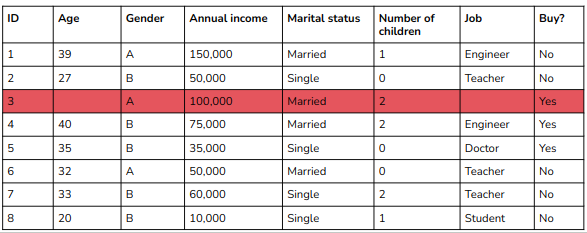
    - <font color='red'>Pésimos casos de uso:</font> 
        1. __Muchos ejemplos tienen valores faltantes.__

            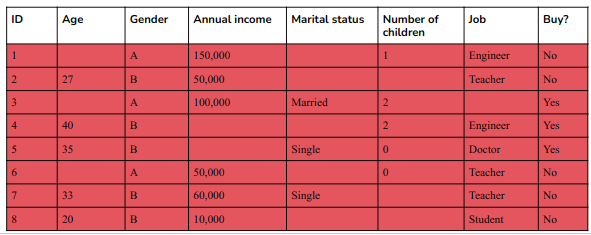
        2. __Valores faltantes no son al azar (MNAR)__. La información faltante es información en sí. 
        - Ejemplo: eliminar muestras con ingresos faltantes (puede significar ingreso más alto).
        
            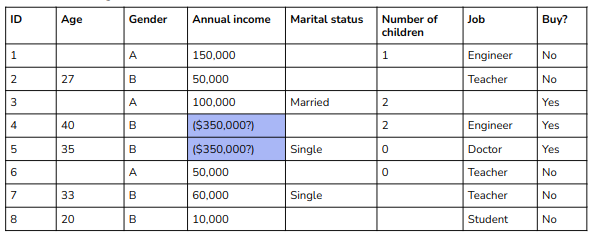
        3. __Valores faltantes son al azar (MAR)__. Puede crear sesgos en el modelo.
        - Ejemplo: sin querer, eliminamos todas las muestras de género A.
            
            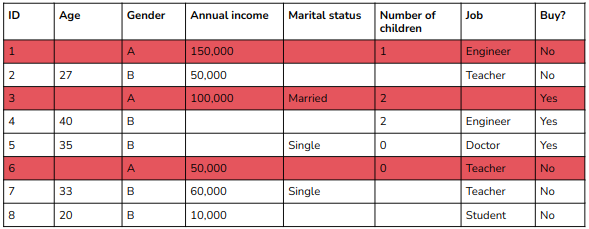

#### 👉 Imputación

Si no quieres eliminar los valores faltantes, tendrás que imputarlos, lo que significa <span style="color: blue;">"rellenarlos con ciertos valores"</span>. Decidir qué “ciertos valores” usar es la parte difícil.

- Valores predeterminados. 
    - Ejemplo: 0, string vacío, etc.
- Medidas estadísticas (media, moda, mediana).
    - Ejemplo: si falta el valor de la temperatura para una muestra de datos en julio, podemos rellenarlo con la temperatura mediana de julio.
- Muchos más métodos [(Ver Documentación Scikit)](https://scikit-learn.org/stable/modules/impute.html).

Ambas prácticas funcionan bien en muchos casos, pero a veces <span style="color: blue;">pueden causar errores difíciles de detectar</span>. Ejemplo: frontend ya no pedía ingresar la edad.

✅ Es una buena práctica <font color='red'>evitar rellenar los valores faltantes con valores posibles</font>. 
- Ejemplo: rellenar el número de hijos faltantes con 0, dificulta distinguir entre personas cuya información falta y personas que no tienen hijos.



<div style="background-color: #f9f9f9; border-left: 4px solid #4CAF50; padding: 10px; font-size: 0.9em;">

💡No hay una manera perfecta de manejar los valores faltantes. 
- Con la eliminación, corres el riesgo de perder información importante o acentuar sesgos. 
- Con la imputación, corres el riesgo de inyectar tu propio sesgo y agregar ruido a tus datos, o peor aún, filtración de datos.

</div>

### 2.2 Escalado/Normalización

Si volvemos al dataset de venta de casas, los valores de la variable "Edad" van de 20 a 40, mientras que los valores de la variable "Ingreso Anual" van de 10k a 150k. Cuando introducimos estas dos variables en un modelo de ML, no entenderá que 150k y 40 representan cosas diferentes: solo los verá como números. Dado que 150k >>> 40, podría darle más importancia, sin importar qué variable sea realmente más útil para generar predicciones. 

Por este motivo, antes de introducir las características en los modelos, es importante <span style="color: blue;">escalarlas para que estén en rangos similares</span>. 
- Es una de las cosas más simples que podemos hacer y suele resultar en un aumento del rendimiento del modelo. 
- No hacerlo puede hacer que el modelo haga predicciones sin sentido, especialmente con algoritmos clásicos como gradient-boosted trees y regresión logística.

#### ¿Normalización es lo mismo que escalado?

Cuando normalizamos estamos cambiando la _forma_ de la distribución, mientras que cuando escalamos estamos cambiando el _rango_ de los datos.
- __Escalado__: Es necesario cuando usamos métodos que se basan en medidas de cercanía entre puntos, como SVM o KNN.
- __Normalización__: El objetivo es transformar las observaciones para que se ajusten a una distribución normal. En general, lo hacemos si vamos a usar un modelo de ML que asume que los datos están distribuidos normalmente (LDA, Gaussian Naive Bayes).

  | **Transformación**      | **Caso de Uso**                                             | **Fórmula**                                  | **Rango**                      |
  |---------------------------|------------------------------------------------------------|---------------------------------------------|--------------------------------|
  | Min/Max      | Cualquier caso: sin suposiciones sobre variables!          |$x' = a + \frac{x - \min(x)}{\max(x) - \min(x)} \cdot (b - a) $ | [a, b]                        |
  | Z-Score Standarization    | Cuando las variables siguen una distribución normal        | $x' = \frac{x - \mu}{\sigma}$              | $-\infty, \infty$           |
  | Log                | Cuando las variables siguen una distribución exponencial  | $x' = \log(x)$                           | $-\infty, \infty$            |




* La <span style="color: blue;">transformación logarítmica es útil para datos sesgados porque reduce la influencia de valores extremos</span>, acercando los outliers al centro de la distribución.
* Esto hace que los <span style="color: blue;">datos sean más simétricos</span>, lo que mejora el rendimiento de modelos que asumen una distribución normal. 

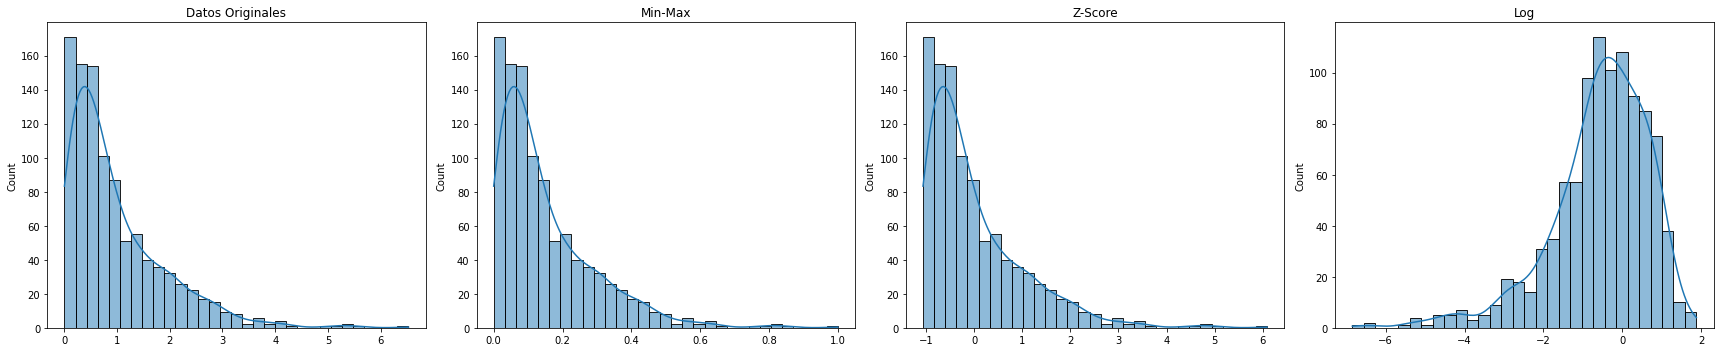

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

original_data = np.random.exponential(size=1000) + 0.001
original_data_reshaped = original_data.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(original_data_reshaped)

log_transformed_data = np.log(original_data_reshaped)

standard_scaler = StandardScaler()
z_score_transformed_data = standard_scaler.fit_transform(original_data_reshaped)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos Originales")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Min-Max")
sns.histplot(z_score_transformed_data, ax=ax[2], kde=True, legend=False)
ax[2].set_title("Z-Score")
sns.histplot(log_transformed_data, ax=ax[3], kde=True, legend=False)
ax[3].set_title("Log")

plt.tight_layout()
plt.show()

Aspectos importantes a tener en cuenta:
1. Puede ser una <span style="color: blue;">fuente común de data leakage</span>. 
2. Requiere estadísticas globales.
    - Tenemos que observar todos los datos de entrenamiento o un subconjunto de ellos para calcular su mínimo, máximo o media. 
    - Durante la <span style="color: blue;">inferencia, reutilizamos las estadísticas obtenidas durante el entrenamiento</span> para escalar nuevos datos. 
    - <span style="color: blue;">Si los nuevos datos cambiaron significativamente</span> en comparación con los datos de entrenamiento, estas <span style="color: blue;">estadísticas no serán muy útiles.</span>
    - Por este motivo es <span style="color: blue;">importante volver a entrenar el modelo con frecuencia</span> para tener en cuenta estos cambios.

### 2.3 Encoding de Features Categóricas

Es el proceso de convertir datos categóricos o textuales en un formato numérico, ya que la mayoría de los algoritmos de machine learning trabajan con números y no con texto o variables categóricas.

Hay dos tipos de datos categóricos:

##### <span style="color: black;">Datos Ordinales</span>
- Tienen un <span style="color: blue;">orden inherente</span>. 
- Es decir, las categorías pueden ser clasificadas o ordenadas de mayor a menor o viceversa.
- Ejemplo, la variable <span style="color: blue;">“título de estudio más alto”</span> es una variable ordinal. Las categorías (Secundaria, Diploma, Licenciatura, Maestría, PhD) pueden ser clasificadas en orden de nivel educativo alcanzado.

##### <span style="color: black;">Datos Nominales</span>
- <span style="color: blue;">No tienen un orden inherente</span>. 
- Es decir, las categorías no pueden ser clasificadas ni ordenadas.
- Ejemplo, la variable <span style="color: blue;">“ciudad de residencia”</span> es una variable nominal. Las categorías (Delhi, Mumbai, Ahmedabad, Bangalore, etc.) no pueden ser clasificadas ni ordenadas.

La elección del método de codificación puede tener un impacto significativo en el rendimiento del modelo, por lo que es <span style="color: blue;">importante seleccionar una técnica de codificación adecuada según la naturaleza de los datos</span> y los requisitos específicos del modelo.

#### 2.3.1 One-Hot Encoding

- Método más común para codificar variables categóricas.
- Se crea una columna binaria para cada categoría única en la variable.
- Si una categoría está presente en una muestra, la columna correspondiente se establece en 1, y todas las demás columnas se establecen en 0.
- Por ejemplo, si una variable tiene tres categorías ‘A’, ‘B’ y ‘C’, se crearán tres columnas y una muestra con la categoría ‘B’ tendrá el valor [0, 1, 0].

In [2]:
import pandas as pd

df = pd.DataFrame({'color': ['red', 'green', 'blue', 'red']})
one_hot = pd.get_dummies(df['color'])
print(one_hot.astype(int))

   blue  green  red
0     0      0    1
1     0      1    0
2     1      0    0
3     0      0    1


#### 2.3.2 Label Encoding

- A cada categoría única se le asigna un valor entero único.

- Este es un método de codificación más sencillo, pero tiene una desventaja: los enteros asignados pueden ser malinterpretados por el algoritmo como si tuvieran una relación ordenada cuando, en realidad, no la tienen.

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['color_label'] = le.fit_transform(df['color'])
print(df)

   color  color_label
0    red            2
1  green            1
2   blue            0
3    red            2


#### 2.3.3 Ordinal Encoding

- Se usa cuando las categorías en una variable tienen un orden natural.

- Por ejemplo, si una variable tiene categorías como ‘Bajo’, ‘Medio’ y ‘Alto’, se les pueden asignar los valores 1, 2 y 3, respectivamente.


In [4]:
df = pd.DataFrame({'quality': ['low', 'medium', 'high', 'medium']})
quality_map = {'low': 0, 'medium': 1, 'high': 2}
df['quality_map'] = df['quality'].map(quality_map)
print(df)

  quality  quality_map
0     low            0
1  medium            1
2    high            2
3  medium            1


#### 2.3.4 Codificación Binaria

- Es similar a la codificación one-hot, pero en lugar de crear una columna separada para cada categoría, las categorías se representan como dígitos binarios.

- Por ejemplo, si una variable tiene cuatro categorías ‘A’, ‘B’, ‘C’ y ‘D’, se pueden representar como 0001, 0010, 0100 y 1000, respectivamente.

In [5]:
df = pd.DataFrame({'animal': ['cat', 'dog', 'bird', 'cat']})
print(f"Before Encoding the Data:\n\n{df}\n")

animal_map = {'cat': 0, 'dog': 1, 'bird': 2}
df['animal'] = df['animal'].map(animal_map)
df['animal'] = df['animal'].apply(lambda x: format(x, 'b'))

print(f"After Encoding the Data:\n\n{df}\n")

Before Encoding the Data:

  animal
0    cat
1    dog
2   bird
3    cat

After Encoding the Data:

  animal
0      0
1      1
2     10
3      0



#### 2.3.5 Count Encoding

- La codificación por conteo es un método para codificar variables categóricas contando el número de veces que aparece una categoría en el conjunto de datos.

- Por ejemplo, si la variable "Producto" tiene las categorías ‘A’, ‘B’ y ‘C’ y la categoría ‘A’ aparece 10 veces en el conjunto de datos, se le asignará un valor de 10. En este caso, la frecuencia de ese producto representa su popularidad. Es decir, un producto con mayor número es más probable de ser vendido.

In [6]:
df = pd.DataFrame({'fruit': ['apple', 'banana', 'grapes', 'banana']})
print(f"Before Encoding the Data:\n\n{df}\n")

counts = df['fruit'].value_counts()
df['fruit'] = df['fruit'].map(counts)

print(f"After Encoding the Data:\n\n{df}\n")

Before Encoding the Data:

    fruit
0   apple
1  banana
2  grapes
3  banana

After Encoding the Data:

   fruit
0      1
1      2
2      1
3      2



#### 2.3.6 Target Encoding

- Es una técnica de codificación más avanzada utilizada para tratar características categóricas con <span style="color: blue;">alta cardinalidad</span>, es decir, características con <span style="color: blue;">muchas categorías</span> únicas.

- Se calcula el <span style="color: blue;">valor promedio del objetivo para cada categoría</span>, y este valor promedio se utiliza para <span style="color: blue;">reemplazar la característica categórica.</span>

- Esta técnica tiene la ventaja de considerar la relación entre el objetivo y la característica categórica, pero también puede llevar al sobreajuste si no se usa con precaución.

In [9]:
df = pd.DataFrame({'fruit': ['apple', 'apple', 'banana', 'grapes', 'grapes', 'banana'],
                   'target': [100, 103, 142, 200, 198, 150]})
print(f"Before Encoding the Data:\n\n{df}\n")

target_mean = df.groupby('fruit')['target'].mean()
df['fruit_label'] = df['fruit'].map(target_mean)
print(f"After Encoding the Data:\n\n{df}")

Before Encoding the Data:

    fruit  target
0   apple     100
1   apple     103
2  banana     142
3  grapes     200
4  grapes     198
5  banana     150

After Encoding the Data:

    fruit  target  fruit_label
0   apple     100        101.5
1   apple     103        101.5
2  banana     142        146.0
3  grapes     200        199.0
4  grapes     198        199.0
5  banana     150        146.0


<span style="color: blue;">En producción, las categorías cambian constantemente</span>, lo que puede causar problemas si tu modelo no está preparado para manejar nuevas categorías o marcas. Veamos un ejemplo.

> ##### Ejemplo: Queremos construir un sistema de recomendación para predecir qué productos podrían querer comprar los usuarios en Mercado Libre. Existen más de 2 millones de marcas que tenemos que recomendar.
>          
>
> ##### 🤔💭 __¿Como encodeamos las diferentes marcas?__
> #####  🤔💭 __En producción, nuestro modelo falla porque encuentra una marca que nunca vió y, por lo tanto, no puede codificar.  ¿Como manejamos nuevas marcas que publican en Mercado Libre?__
> Encodeamos marcas no vistas durante el entrenamiento como "UNKNOWN".
> #####  🤔💭 __El modelo ya no falla en producción! Pero... los vendedores se quejan de que sus nuevas marcas no están recibiendo tráfico. ¿Por qué ocurre esto y como lo solucionamos?__
> Nuestro modelo no vio la categoría UNKNOWN en el conjunto de entrenamiento, por lo que simplemente no recomienda ningún producto de la marca UNKNOWN. Solucionamos esto codificando solo las 99% marcas más populares y codificando el 1% inferior como UNKNOWN. De esta manera, al menos nuestro modelo sabe cómo manejar las marcas UNKNOWN. 
> #####  🤔💭 __Nuestro modelo está funcionando bien, pero ahora Nike quiere unirse a Mercado Libre como vendedor. ¿Pueden identificar cual puede ser el siguiente problema?__
> Nuestro modelo va a tratar a todas las marcas nuevas (ya sean de lujo, de imitación dudosa o marcas consolidadas) de la misma manera que trata a las marcas menos populares (durante entrenamiento) de Mercado Libre.
> ##### 🤔💭 __Entonces: ¿Cómo hacemos para implementar un método flexible para manejar nuevas marcas a medida que son introducidas en nuestro sistema?__
> Una solución a este problema es el truco de hashing: usas una función hash para generar un valor hash de cada categoría. El valor hash se convierte en el índice de esa categoría.
> - Ejemplo: hash("Nike") = 0, hash("Adidas") = 27, etc.
> - Ventajas: podemos elegir que tan grande es el espacio de hashing.
> - Desventajas: dos categorías podrían estar hasheadas al mismo índice.

### 2.5 Feature Crossing (Combinación de Features)

- Un <span style="color: blue;">modelo lineal que utiliza one-hot encoding</span> para cada variable categórica puede capturar los efectos principales de cada variable, pero <span style="color: blue;">no puede capturar los efectos de interacción</span> entre ellas. 
- Por ejemplo, supongamos que queremos predecir la eficiencia de combustible de un vehículo dadas dos variables categóricas de entrada: 
    - El <span style="color: blue;">tipo de vehículo</span> (por ejemplo, SUV (S), Camioneta (T) o Auto familiar (F)) y 
    - El <span style="color: blue;">país de origen</span> (por ejemplo, USA (U) o Japón (J)). 
- Si concatenamos las codificaciones one-hot para las características ternarias y binarias, obtenemos la siguiente codificación de entrada:

    $$
    \phi(x) = [1, I (x_1 = S) , I (x_1 = T ) , I (x_1 = F ) , I (x_2 = U ) , I (x_2 = J)]
    $$ 
    donde $x_1$ es el tipo de vehículo y $x_2$ es el país de origen. 

- Este modelo no puede capturar dependencias entre las características. 
- Por ejemplo, esperamos que las camionetas sean menos eficientes en el consumo de combustible, pero tal vez las camionetas de USA sean incluso menos eficientes que las camionetas de Japón. Esto no se puede capturar utilizando el modelo lineal en la ecuación anterior, ya que la contribución del país de origen es independiente del tipo de vehículo.

- Podemos solucionar esto calculando cruces de características explícitas. 
- Por ejemplo, podemos definir una nueva característica compuesta con 3 × 2 valores posibles para capturar la interacción entre el tipo de vehículo y el país de origen. El nuevo modelo se convierte en:

$$
f (x; w) = w^T\phi(x) 
= w_0 + w_1I (x_1 = S) + w_2I (x_1 = T ) + w_3I (x_1 = F ) + w_4I (x_2 = U ) + w_5I (x_2 = J ) + w_6I (x_1 = S, x_2 = U ) + \\ w_7I (x_1 = T, x_2 = U ) + w_8I (x_1 = F, x_2 = U ) + w_9I (x_1 = S, x_2 = J ) + w_{10}I (x_1 = T, x_2 = J ) + w_{11}I (x_1 = F, x_2 = J )
$$

- Esto convierte el conjunto de datos original en un formato más amplio, con muchas más columnas.

- Debido a que ayuda a modelar relaciones no lineales entre variables, es muy <span style="color: blue;">útil en modelos que no pueden aprender relaciones no lineales</span>(regresión lineal, la regresión logística y los modelos basados en árboles).
- No es tan importante en redes neuronales, pero igualmente puede ser útil porque el cruce explícito a veces las ayuda a aprender relaciones no lineales más rápido.
- <font color='red'>Cuidado:</font> feature crossing puede explotar el espacio de características.
    - Ejemplo: Features A y B tienen 100 categorías c/u → El cruce (Feature AxB) tendrá 100000 valores posibles!
    - <span style="color: blue;">Necesitamos MUCHOS más datos</span> para que el modelo aprenda todos los valores posibles.
    - Explotar el espacio de features aumenta el <span style="color: blue;">riesgo de overfitting</span> (puede hacer que los modelos se ajusten en exceso a los datos de entrenamiento.)

## 3. Data Leakage

### 3.1 ¿Qué es el Data Leakage?
- Ocurre cuando la <span style="color: blue;">información del conjunto de prueba se filtra al conjunto de entrenamiento</span>, afectando la validez del modelo.
- Esta misma información no está disponible durante la inferencia.
- Es muy desafiante porque, por lo general, no es obvia. Es peligrosa porque <span style="color: blue;">puede hacer que tus modelos fallen de manera inesperada</span>, incluso después de una evaluación y pruebas exhaustivas. 
- Ejemplo: <span style="color: blue;">“Hundreds of AI Tools Have Been Built to Catch Covid. None of Them Helped”</span>, MIT Technology Review, Julio 2021.

<div class="alert alert-block alert-info" style="background-color: #d0e8f2; border-color: #d0e8f2; color: #000;">
<b>Ejemplo 1: Detección de cáncer de pulmón usando tomografías computarizadas (CT)</b> 

- Data: recolectada del hospital A
- Tiene buena performance sobre el test set del hospital A.
- Tiene muy mala performance sobre el test set del hospital B.
- Features:

  | Patient ID | Date |Doctor note | Medical record | Scanner type | CT scan |
  |---|---|---|---|---|---|

<b>¿Qué puede haber ocurrido?</b> 
</div>

- Después de investigar, descubrimos que en el <span style="color: blue;">Hospital A</span>, los pacientes que se sospecha tienen cáncer de pulmón son enviados a <span style="color: blue;">una máquina de escaneo más avanzada</span>, que produce imágenes diferentes. 
- El modelo aprendió a predecir el cáncer <span style="color: blue;">
basándose en la máquina de escaneo</span>, pero el Hospital B usa equipos al azar, lo que causa que el modelo no funcione bien. 
- Esto muestra que __las etiquetas se filtraron en las características durante el entrenamiento__.

<div class="alert alert-block alert-info" style="background-color: #d0e8f2; border-color: #d0e8f2; color: #000;">
<b>Ejemplo 2: Predicción del número de views de un artículo</b> 

- Data: información histórica del sitio web.
- Features:

  | Article ID | Date |Title | Article | Author | Language | Translations |
  |---|---|---|---|---|---|---|

<b>¿De donde puede venir el data leakage?</b> 
</div>

- Después de investigar, descubrimos que el sitio web solamente <span style="color: blue;">traduce artículos</span> que están siendo muy <span style="color: blue;">
populares</span>.

### 3.2 Causas típicas del Data Leakage

#### 3.2.1 División de Datos Correlacionados Temporalmente

- <span style="color: blue;">Dividir aleatoriamente</span> los datos en conjuntos de entrenamiento, validación y prueba puede causar filtración de datos.
- <span style="color: blue;">Algunos datos estan correlacionados temporalmente.</span>
    - Ejemplo 1: precios de las acciones.
        - Acciones similares tienden a moverse juntos.
        - Si el 90% de las acciones tecnológicas bajan hoy, es muy probable que el otro 10% también baje.
    - Ejemplo 2: predecir si alguien hará clic en una recomendación de canción. 
        - No solo depende del gusto musical individual, sino también de la tendencia musical general del día.
        - Si fallece un artista, probablemente más personas escuchen sus canciones ese día. Incluir muestras de ese día filtra información sobre la tendencia musical.
- __Prevención: Dividir los datos por tiempo.__
    - Entrenamos con datos de los primeros días y evaluamos con datos de días posteriores.
    - Sino, los precios de los días posteriores pueden aparecer en el conjunto de entrenamiento y filtrar información sobre las condiciones del mercado en ese día.

    
    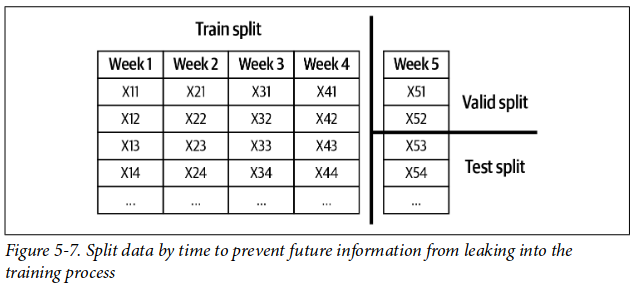

#### 3.2.2 Escalado Antes de la División de Datos

- El <span style="color: blue;">escalado requiere estadísticas globales</span>, como la media y la varianza, de tus datos.
- Error típico: 
    - Usar los datos completos para generar estas estadísticas globales antes de dividir los datos en diferentes conjuntos.
    - Esto <span style="color: blue;">puede filtrar la media y la varianza de las muestras de prueba en el proceso de entrenamiento</span>, permitiendo que el modelo ajuste sus predicciones para esas muestras de prueba. 
- <span style="color: blue;">En producción</span>, esta información <span style="color: blue;">no está disponible</span>, por lo que el rendimiento del modelo probablemente baje. 
- __Prevención: Dividir los datos antes de escalarlos__. 
    - Después, usamos las estadísticas del conjunto de entrenamiento para escalar todos los conjuntos.

#### 3.2.3 Imputación de Datos Faltantes con Estadísticas del Conjunto de Prueba
- Error típico: 
    - Rellenar los valores faltantes de una característica con la media o la mediana de todos los valores presentes. 
    - Este tipo de filtración es <span style="color: blue;">similar a la causada por el escalado</span> y se puede prevenir utilizando únicamente las estadísticas del conjunto de entrenamiento para rellenar los valores faltantes en todos los conjuntos.
- __Prevención: Dividir los datos antes de imputar valores faltantes__. Asegúrate de calcular la media o la mediana solo a partir del conjunto de entrenamiento y usar estos valores para rellenar los datos faltantes en todos los conjuntos.

#### 3.2.4 Manejo Deficiente de la Duplicación de Datos Antes de la División

- Si hay datos duplicados, no eliminarlos antes de dividir los datos puede hacer que las <span style="color: blue;">mismas muestras aparezcan tanto en el conjunto de entrenamiento como en el de validación/prueba.</span>
- La duplicación de datos es bastante común en la industria y también se ha encontrado en conjuntos de datos de investigación populares.
    - Por ejemplo, CIFAR-10 y CIFAR-100, dos conjuntos de datos populares utilizados en investigación de visión por computadora, fueron lanzados en 2009, pero no fue hasta 2019 que Barz y Denzler descubrieron que el 3.3% y el 10% de las imágenes de los conjuntos de prueba de CIFAR-10 y CIFAR-100 tienen duplicados en el conjunto de entrenamiento.

Causas de la Duplicación de Datos:

1. <span style="color: blue;">Recolección de Datos</span>: Al combinar diferentes fuentes de datos, puede ocurrir duplicación si una fuente ya contiene datos de otra.
2. <span style="color: blue;">Procesamiento de Datos</span>: Técnicas como el sobremuestreo pueden resultar en la duplicación de ciertos ejemplos.

- __Prevención__:

    - Verificar Duplicados Antes y Después de la División: Revisa nuevamente después de la división para confirmar que no hay duplicados entre los conjuntos.
    - Sobremuestreo Después de la División: Realiza cualquier sobremuestreo solo después de haber dividido los datos para evitar la duplicación de muestras entre los conjuntos.

#### 3.2.5 Filtración por Grupos

- <span style="color: blue;">Un grupo de ejemplos con etiquetas altamente correlacionadas</span> se divide en diferentes conjuntos de datos. 
    - Ejemplo 1: paciente con 2 CT tomadas con una semana de diferencia, ambas con la misma etiqueta (cáncer o no). Si una de estas imágenes está en el conjunto de entrenamiento y la otra en el conjunto de prueba, se produce una filtración por grupos.
    - Ejemplo 2: en tareas como la detección de objetos, algunas imágenes de un mismo objeto, tomadas en milisegundos de diferencia, pueden estar distribuidas en los conjuntos de entrenamiento y prueba.
- __Prevención: Conocimiento de la Generación de Datos__. Tenemos que entender cómo se generan los datos. 

#### 3.2.6 Filtración del Proceso de Generación de Datos
- Ocurre cuando la <span style="color: blue;">forma en que se genera o se recoge la información introduce sesgos</span> que afectan el modelo. 
- Ejemplo: el caso donde la información sobre si una tomografía muestra signos de cáncer de pulmón se filtra a través de la máquina de escaneo utilizada. 
- <span style="color: blue;">Detectarlo requiere comprensión profunda de cómo se recopilan los datos.</span>
    - No es facil identificar que el rendimiento deficiente se debe a scanners diferentes si no sabemos que los procedimientos y/o equipos de los hospitales son diferentes.
- __Prevención__:
    - <span style="color: blue;">Rastreo de Fuentes</span>: Mantener un registro de las fuentes de tus datos y comprender cómo se recopilan y procesan.
    - <span style="color: blue;">Normalización de Datos</span>: Normalizar los datos para que la información de diferentes fuentes tenga medias y varianzas similares. 
        - Por ejemplo, si diferentes máquinas de CT producen imágenes con resoluciones distintas, normalizar todas las imágenes a una misma resolución puede dificultar que el modelo identifique la máquina de escaneo original.
    - <span style="color: blue;">Incorporación de Expertos</span>: Involucrar a expertos que tengan contexto sobre cómo se recopilan y utilizan los datos en el proceso de diseño del modelo.

### 3.3 Detección de Filtración de Datos
- Puede ocurrir en varias etapas, desde la generación y recopilación de datos hasta el muestreo, la división y el procesamiento de datos.
- <span style="color: blue;">Crucial estar atentos al data leakage durante __todo el ciclo de vida del proyecto__</span>.
- Estrategias:
    1. <span style="color: blue;">Medir el Poder Predictivo de las Características</span>
        - Evaluar la <span style="color: blue;">correlación de cada característica con respecto a la variable objetivo.</span>
        - Si hay una correlación inusualmente alta, investigar cómo se genera esa feature y si esa correlación tiene sentido.
        - Tener en cuenta que a veces 2 features no tienen filtración por si solas pero sí en conjunto.
            - Ejemplo: para predecir cuánto tiempo permanecerá un empleado en una empresa, la fecha de inicio y la fecha de finalización por separado no dicen mucho sobre su permanencia, pero juntas proporcionan esa información.
    2. <span style="color: blue;">Estudios de Ablación</span>
        - Medir la importancia de una característica en el modelo.
        - Si eliminar una característica causa una disminución significativa en el rendimiento del modelo, investiga por qué esa característica es tan importante. 
        - Aunque puede ser inviable realizarlo para todas las combinaciones de features, aún es útil realizar estos estudios ocasionalmente con un subconjunto de características que sospechas más.
    3. <span style="color: blue;">Monitoreo de Nuevas Características</span>
        - Si agregar una nueva característica mejora significativamente el rendimiento del modelo, podría ser que esa característica sea realmente útil o que contenga información filtrada sobre las etiquetas. 


## 4. Engineering Good Features (Ingeniería de Buenas Features)

- Agregar más features generalmente mejora el rendimiento del modelo. 
- Pero... <span style="color: blue;">tener demasiadas características puede ser perjudicial tanto durante el entrenamiento como al servir el modelo</span>, por las siguientes razones:

    1. Cuantas más características, <span style="color: blue;">más chances de data leakage.</span>
    2. Demasiadas features pueden causar <span style="color: blue;">overfitting</span>.
    3. Un gran número de features puede <span style="color: blue;">aumentar la memoria necesaria para servir el modelo</span>, lo que podría requerir máquinas o instancias más costosas.
    4. Un exceso de características puede <span style="color: blue;">incrementar la latencia en la inferencia cuando se realizan predicciones en línea</span>, especialmente si es necesario extraer estas características de datos crudos para hacer predicciones en tiempo real.
    5. Las características inútiles se convierten en <span style="color: blue;">deudas técnicas</span>. Cuando cambia tu pipeline de datos, todas las características afectadas deben ajustarse. Por ejemplo, si tu aplicación deja de aceptar la edad de los usuarios, las características relacionadas con la edad deben actualizarse.

- En teoría, si una característica no ayuda a un modelo a hacer buenas predicciones, técnicas como la regularización L1 deberían reducir el peso de esa característica a 0. 
- Sin embargo, en la práctica, puede ser útil eliminar las características que ya no son útiles para que el modelo aprenda más rápido.
- Hay dos factores que pueden considerar al evaluar si una característica es buena para un modelo: 
    1. Su importancia para el modelo y 
    2. Su generalización a datos no vistos.


### 4.1 Feature Importance
- Evaluación de la importancia de las características en un modelo.
- El algoritmo exacto para medir la importancia de las características es complejo. 
- Intuitivamente, <span style="color: blue;">se mide por cuánto se deteriora el rendimiento del modelo si se elimina esa característica</span> o un conjunto de características que la incluye. 
- SHAP (SHapley Additive exPlanations) no solo mide la importancia de una característica para el modelo en general, sino que también evalúa la contribución de cada característica a una predicción específica del modelo.

    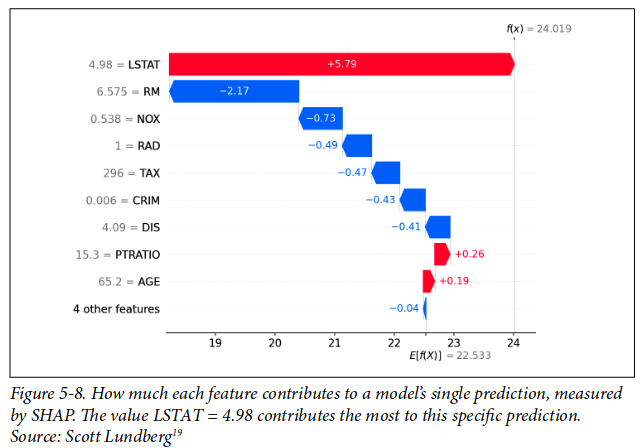
- No solo son útiles para seleccionar las características adecuadas, sino que las técnicas de feature importance también sirven para la <span style="color: blue;">interpretabilidad</span>, ya que te ayudan a comprender cómo funcionan tus modelos internamente.

## 5. Bibliografia

1. Huyen, C. (2022). *Designing machine learning systems: An iterative process for production-ready applications*. O'Reilly Media.

2. Murphy, K. P. (2022). *Probabilistic machine learning: An introduction*. MIT Press.
